In [80]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [60]:
class ConvMixerLayer(nn.Module):
    """ The ConvMixer block with:
    - Depth-Wise Convolution ("depth" here means the patch embedding size/channels ("embedding_dim" in the model code),
        not the mixer block depth)
    - skip connection
    - Point-Wise Convolution.
    """
    def __init__(self, dim, kernel_size, dropout_rate):
        super().__init__()

        # depth wise Convolution layer (convolution across embeddings for each channel)
        self.depth_wise_conv = nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )

        # point wise Convolution layer (convolution across channels for each embedding)
        self.point_wise_conv = nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
                )
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # residual connection after depth wise convolution
        residual = self.depth_wise_conv(x)
        residual = residual + x
        residual = self.dropout(residual)
        x = self.point_wise_conv(residual)
        return self.dropout(x)

class ConvMixer(nn.Module):
    """ The ConvMixer architecture with:
       1) Patch Embedding with size embedding_dim
       2) ConvMixerLayer block with specified block_depth
       3) Global Average Pooling and flattening
       4) Classifier
    """
    def __init__(self, channels=3, embedding_dim=128, block_depth=5, kernel_size=10,
                 patch_size=8, dropout_rate=0.3, num_classes=10):
        super().__init__()

        # convert image to 
        self.patch_embedding = nn.Sequential(nn.Conv2d(channels, embedding_dim, kernel_size=patch_size, stride=patch_size),
                                             nn.GELU(),
                                             nn.BatchNorm2d(embedding_dim)
                                            )

        self.conv_mixer_layers = nn.ModuleList([ConvMixerLayer(embedding_dim, kernel_size, dropout_rate) for _ in range(block_depth)])

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)              # Patch Embedding layer
        for mixerBlock in self.conv_mixer_layers:     # Applying Mixer Layer "depth" times
            x = mixerBlock(x)
        x = self.avgpool(x)
        x = self.flatten(x)                      # Global Average Pooling

        return self.classifier(x)

In [61]:
# Convert the data to Tensor
transform = transforms.ToTensor()

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [62]:
img_shape = train_data[0][0].shape
label = train_data[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")
train_data

Image shape: torch.Size([3, 32, 32])
Label: 6


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [70]:
def train_nn(model, train_loader, criterion, optimizer, device):
    """Function to train the neural network for one epoch"""
    model.train()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    # using gradient scaler
    scaler = torch.cuda.amp.GradScaler()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_labels = torch.argmax(outputs, dim=1)
        total_labels += labels.size(0)
        correct_labels += torch.sum(predicted_labels == labels).item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_labels / total_labels
    
    return train_loss, train_accuracy

In [71]:
def evaluate_nn(model, test_loader, criterion, device):
    """
    Function to evaluate the neural network on the test data.
    """
    model.eval()
    running_loss = 0.0
    correct_labels = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted_labels = torch.argmax(outputs, dim=1)
            total_labels += labels.size(0)
            correct_labels += torch.sum(predicted_labels == labels).item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct_labels / total_labels
    return test_loss, test_accuracy

In [72]:
def custom_lr_scheduler(optimizer, epoch, init_lr=0.1, warmup_epochs=4, decay_rate=0.5, decay_epochs=2):
    """Custom LR scheduler with warmup and decay"""
    if epoch < warmup_epochs:
        lr = init_lr * (epoch + 1) / warmup_epochs
    else:
        lr = init_lr * (decay_rate ** ((epoch - warmup_epochs) // decay_epochs))
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [73]:
# Training and Evaluation Function
def run_training(lr, num_epochs, model, batch_size, weight_decay=1e-4):
    """
    Function to train and evaluate the model for a given number of epochs with custom LR scheduling, dropout, and weight decay.
    """

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    # Loss function and optimizer with weight decay for L2 regularization
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Lists to store training metrics
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    learning_rates = []  # List to store learning rates for each epoch

    # Training loop with custom LR scheduling
    for epoch in tqdm(range(num_epochs)):
        # Update learning rate using the custom scheduler and store it
        current_lr = custom_lr_scheduler(optimizer, epoch, init_lr=lr)
        learning_rates.append(current_lr)

        # Training step
        train_loss, train_accuracy = train_nn(model, train_loader, criterion, optimizer, device)
        
        # Evaluation step
        test_loss, test_accuracy = evaluate_nn(model, test_loader, criterion, device)

        # Save metrics for analysis
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"LR: {current_lr:.6f}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    # Return model and training metrics
    return model, train_losses, train_accuracies, test_losses, test_accuracies, learning_rates

In [76]:
hidden_dim = 256
lr = 0.001
num_epochs = 15
weight_decay = 1e-4
block_depth= 3
kernel_size=5
patch_size=2
batch_size=128
dropout_rate = 0.3

# Initialize device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvMixer(embedding_dim=hidden_dim, block_depth=block_depth,
                  kernel_size=kernel_size, patch_size=patch_size, dropout_rate=dropout_rate).to(device)

# Call the model training function
model, train_losses, train_accuracies, test_losses, test_accuracies, learning_rates = run_training(
    num_epochs=num_epochs, weight_decay=weight_decay, model=model, batch_size=batch_size, lr=lr
)

  7%|█████▌                                                                             | 1/15 [00:29<06:53, 29.53s/it]

Epoch 1/15
LR: 0.000250, Train Loss: 1.6351, Train Acc: 0.4064
Test Loss: 1.5312, Test Acc: 0.4465


 13%|███████████                                                                        | 2/15 [00:59<06:26, 29.72s/it]

Epoch 2/15
LR: 0.000500, Train Loss: 1.2765, Train Acc: 0.5440
Test Loss: 1.3217, Test Acc: 0.5361


 20%|████████████████▌                                                                  | 3/15 [01:29<05:57, 29.80s/it]

Epoch 3/15
LR: 0.000750, Train Loss: 1.1020, Train Acc: 0.6079
Test Loss: 1.1174, Test Acc: 0.6156


 27%|██████████████████████▏                                                            | 4/15 [01:59<05:28, 29.87s/it]

Epoch 4/15
LR: 0.001000, Train Loss: 0.9757, Train Acc: 0.6551
Test Loss: 1.0108, Test Acc: 0.6549


 33%|███████████████████████████▋                                                       | 5/15 [02:29<05:00, 30.07s/it]

Epoch 5/15
LR: 0.001000, Train Loss: 0.8641, Train Acc: 0.6931
Test Loss: 0.8920, Test Acc: 0.6916


 40%|█████████████████████████████████▏                                                 | 6/15 [03:00<04:31, 30.20s/it]

Epoch 6/15
LR: 0.001000, Train Loss: 0.7808, Train Acc: 0.7230
Test Loss: 0.8075, Test Acc: 0.7224


 47%|██████████████████████████████████████▋                                            | 7/15 [03:30<04:02, 30.29s/it]

Epoch 7/15
LR: 0.000500, Train Loss: 0.6850, Train Acc: 0.7605
Test Loss: 0.7505, Test Acc: 0.7444


 53%|████████████████████████████████████████████▎                                      | 8/15 [04:01<03:34, 30.59s/it]

Epoch 8/15
LR: 0.000500, Train Loss: 0.6489, Train Acc: 0.7726
Test Loss: 0.7540, Test Acc: 0.7452


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [04:33<03:05, 30.96s/it]

Epoch 9/15
LR: 0.000250, Train Loss: 0.6002, Train Acc: 0.7881
Test Loss: 0.7064, Test Acc: 0.7598


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [05:20<02:58, 35.75s/it]

Epoch 10/15
LR: 0.000250, Train Loss: 0.5771, Train Acc: 0.7993
Test Loss: 0.7026, Test Acc: 0.7662


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [06:23<02:56, 44.09s/it]

Epoch 11/15
LR: 0.000125, Train Loss: 0.5548, Train Acc: 0.8070
Test Loss: 0.6805, Test Acc: 0.7724


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [07:26<02:29, 49.86s/it]

Epoch 12/15
LR: 0.000125, Train Loss: 0.5394, Train Acc: 0.8111
Test Loss: 0.6606, Test Acc: 0.7811


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [08:29<01:47, 53.87s/it]

Epoch 13/15
LR: 0.000063, Train Loss: 0.5269, Train Acc: 0.8169
Test Loss: 0.6609, Test Acc: 0.7810


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [09:27<00:55, 55.14s/it]

Epoch 14/15
LR: 0.000063, Train Loss: 0.5229, Train Acc: 0.8162
Test Loss: 0.6654, Test Acc: 0.7811


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [10:22<00:00, 41.53s/it]

Epoch 15/15
LR: 0.000031, Train Loss: 0.5149, Train Acc: 0.8203
Test Loss: 0.6673, Test Acc: 0.7801


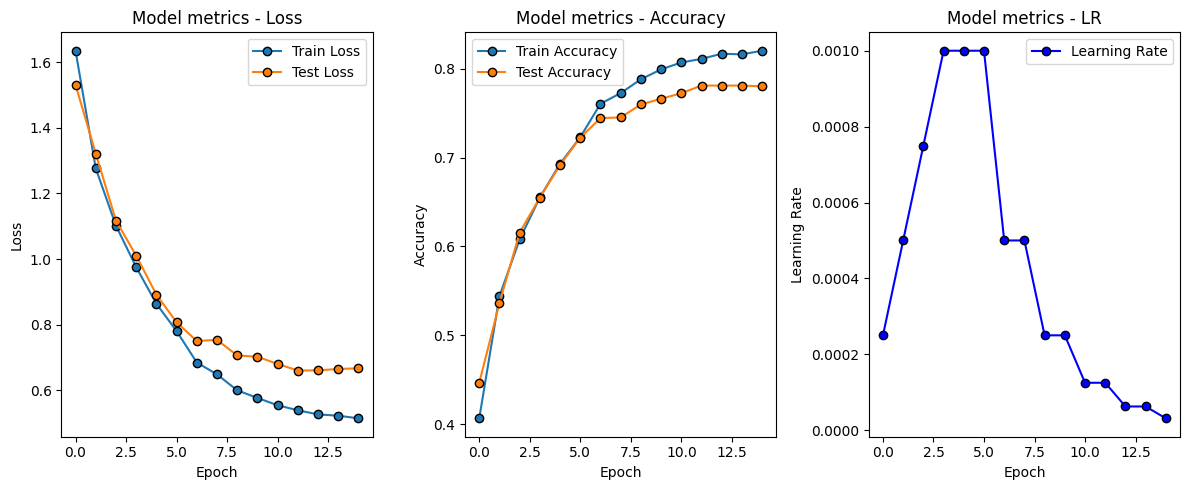

In [77]:
# plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', marker='o', markeredgecolor='black')
plt.plot(test_losses, label='Test Loss', marker='o', markeredgecolor='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model metrics - Loss')

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o', markeredgecolor='black')
plt.plot(test_accuracies, label='Test Accuracy', marker='o', markeredgecolor='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model metrics - Accuracy')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(learning_rates, label='Learning Rate', marker='o', markeredgecolor='black', color='blue')
# plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Model metrics - LR')
plt.tight_layout()

plt.show()

## Observations

## Best performing hyperparameters + config
hidden_dim = 256 \
lr = 0.001 \
num_epochs = 15 \
weight_decay = 1e-4 \
block_depth= 3 \
kernel_size=5 \
patch_size=2 \
batch_size=128 \
dropout_rate = 0.3

Model starts to overfit in the last few epochs.


### Overfitting hyperparameters:
Larger patch and kernel sizes were the determining factors in overfitting. \
with larger Patch and Kernel sizes model was overfitting within 3 epochs. \
Reducing them (see below from #6) lead to a more balanced learning.

#### 1)
hidden_dim = 256 \
lr = 0.001 \
num_epochs = 10 \
depth = 10 \
weight_decay = 1e-4 \
kernel_size=10 \
patch_size=8 \
batch_size=128

#### 2)
hidden_dim = 256 \
lr = 0.001 \
num_epochs = 10 \
weight_decay = 1e-4 \
block_depth=5 <======\
kernel_size=10 \
patch_size=8 \
batch_size=128

#### 3)
hidden_dim = 256 \
lr = 0.001 \
num_epochs = 10 \
weight_decay = 1e-4 \
block_depth=5 \
kernel_size=10 \
patch_size=8 \
batch_size=64 <=====

#### 4)
hidden_dim = 256 \
lr = 0.0001 <======\
num_epochs = 1 <======\
weight_decay = 1e-4 \
block_depth=20 <======\
kernel_size=10 \
patch_size=8 \
batch_size=64

#### 5)
hidden_dim = 256 \
lr = 0.001 <======\
num_epochs = 6 <=====\
weight_decay = 1e-4 \
block_depth=3 <=====\
kernel_size=10 \
patch_size=8 \
batch_size=64

#### 6)
hidden_dim = 256 \
lr = 0.001 \
num_epochs = 10 <=======\
weight_decay = 1e-4 \
block_depth=3 <========\
kernel_size=7 <======\
patch_size=4 <======\
batch_size=64

#### 7)
hidden_dim = 256 \
lr = 0.001 \
num_epochs = 10 \
weight_decay = 1e-4 \
block_depth=3 \
kernel_size=5 <========\
patch_size=2 <========\
batch_size=64

#### 8)
++ gradient_scaler <========
hidden_dim = 256 \
lr = 0.001 \
num_epochs = 10 \
weight_decay = 1e-4 \
block_depth=3 \
kernel_size=5 <========\
patch_size=2 <========\
batch_size=64

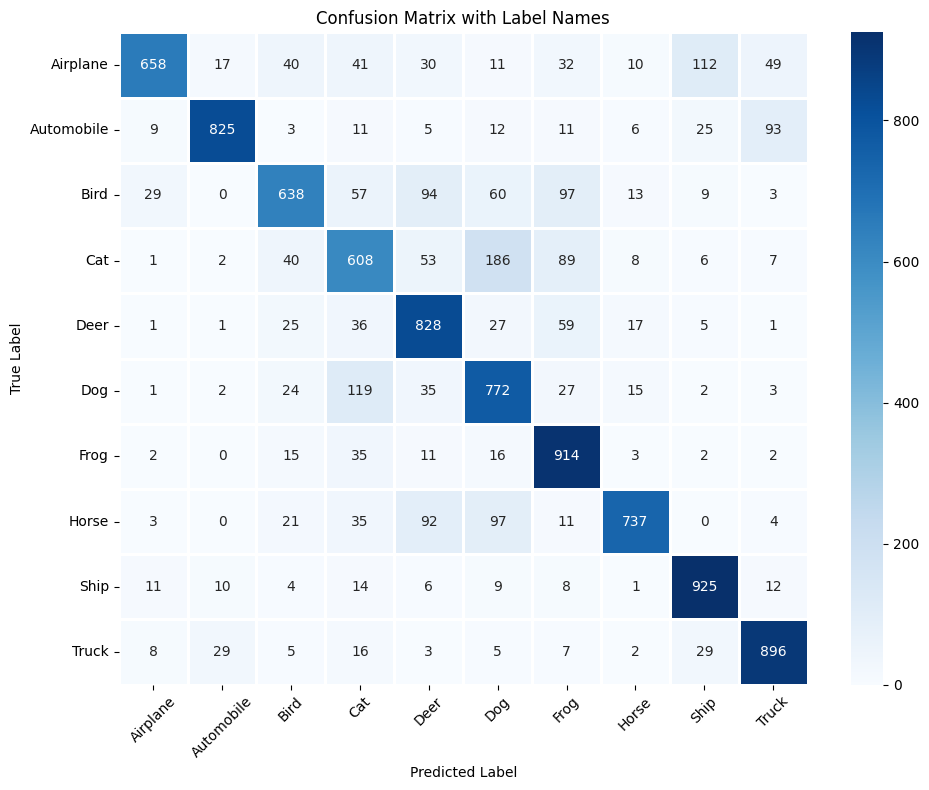

In [81]:
# Function to get predictions and true labels
def get_predictions(model, loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels)

# Get predictions
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_pred, y_true = get_predictions(model, test_loader, device)

label_names = ["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog",
    "Horse","Ship","Truck"]

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names, linewidths=1)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Label Names')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()